# "Reverse" learning MODIS ---> ERA


So far we have looked mainly at taking a bunch of ERA data and trying to learn the MODIS LST.

We can also come at the problem from the other direction: given a MODIS LST, can we learn the ERA skin temperature?


## 1. Which features to use?

In the ERA --> MODIS case, we took a selection of features (see e.g. the `Analysis` notebooks) that were ERA variables.

In this new case we dont have "access" to these features: we can only use MODIS LST + variables which are constant for a given grid point.

We can quantify the time variability of the various ERA features. This is done in `scripts/variability.py` for a year of data (2018).


We do this on a monthly grain as follows:

* For every grid point, for every feature, get the standard deviation over the time period
* For every grid point, for every feature, get the mean over the time period
* Calculate coefficeint of variation, variance/mean i.e. a normalised variance measure
* Take the average over all grid points, giving us one variance metric per feature per month


Features which are constant have small (zero) coefficients, non constant features have larger coefficients (CoV = 1 is BIG).


Lets look at the results:


In [2]:
import pandas as pd
import sys
import xarray as xr
import glob

#Data paths
variation_files = glob.glob("../scripts/small_data/variation*.pkl")

#Load it all
dfs = []
for f in variation_files:
    df = pd.read_pickle(f)
    dfs.append(df) 
    

#...and put it into a single dataframe
df = pd.concat(dfs).reset_index()
df['time'] = pd.to_datetime(df['dt']) #make it a datetime object, not string
df['variability'] = abs(df['CV']) #Coefficient can be positive or negative - we just care about magnitudes

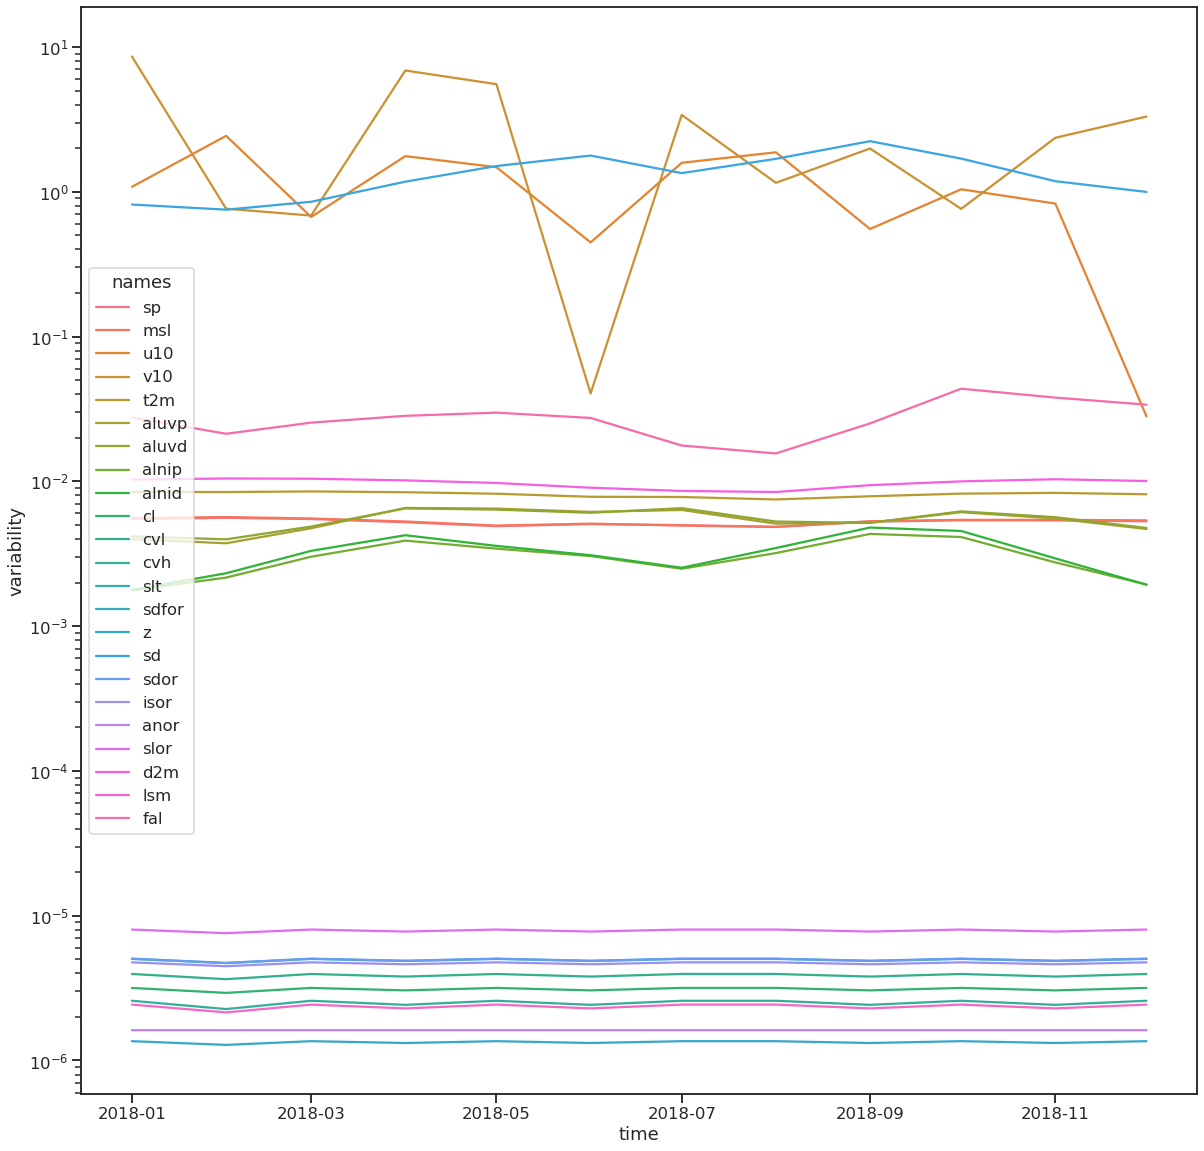

In [3]:
#Plot it 
import seaborn as sns
import matplotlib.pyplot as plt

h,w = 20,20

sns.set_theme(context='talk', 
                  style='ticks', 
                  palette='deep',
                  rc={'figure.figsize':(h,w)}
                  )

    
#Figure
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(h,w))
    
    #Plot
p = sns.lineplot(data=df, x='time', y='variability',hue='names',ax=ax1,markers=True)
  
ax1.set_yscale('log')

This figure is a bit hard to read, but there are clearly a bunch of variables with **small but non-zero** variances.

We can also look at the average over time:

In [4]:
df_grouped = df.groupby("names").mean()
df_grouped.sort_values("variability")

index        CV  variability
names                              
slt      7.0  0.000000     0.000000
z        9.0  0.000001     0.000001
anor    13.0  0.000002     0.000002
lsm     16.0  0.000002     0.000002
cvh      6.0  0.000003     0.000003
cl       4.0  0.000003     0.000003
cvl      5.0  0.000004     0.000004
isor    12.0  0.000005     0.000005
sdfor    8.0  0.000005     0.000005
sdor    11.0  0.000005     0.000005
slor    14.0  0.000008     0.000008
alnip    2.0  0.003013     0.003013
alnid    3.0  0.003209     0.003209
sp       0.0  0.005241     0.005241
msl      1.0  0.005283     0.005283
aluvp    0.0  0.005385     0.005385
aluvd    1.0  0.005462     0.005462
t2m      4.0  0.008140     0.008140
d2m     15.0  0.009742     0.009742
fal     17.0  0.027800     0.027800
u10      2.0 -0.213850     1.148209
sd      10.0  1.334966     1.334966
v10      3.0 -0.034016     2.954510

This is a little strange - I would expect something like `lsm` to have zero variance - surely the land sea mask applied to a grid point does not change over time?

This is probably just a machine epsilon issue, but we can check in more detail:

In [5]:
#Load a month of ERA data
root = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/' 
fname = root + 'ERA_skin/sfc_skin_unstructured_2018_01.grib'
ds = xr.open_dataset(fname,engine='cfgrib',filter_by_keys={'typeOfLevel': 'surface'})

Ignoring index file '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/ERA_skin/sfc_skin_unstructured_2018_01.grib.923a8.idx' incompatible with GRIB file


In [6]:
#we can look just at lsm
ds['lsm']

<xarray.DataArray 'lsm' (time: 744, values: 542080)>
[403307520 values with dtype=float32]
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2018-01-01 ... 2018-01-31T23:00:00
    step        timedelta64[ns] ...
    surface     float64 ...
    latitude    (values) float64 ...
    longitude   (values) float64 ...
    valid_time  (time) datetime64[ns] ...
Dimensions without coordinates: values
Attributes:
    GRIB_paramId:                    172
    GRIB_dataType:                   an
    GRIB_numberOfPoints:             542080
    GRIB_typeOfLevel:                surface
    GRIB_stepUnits:                  1
    GRIB_stepType:                   instant
    GRIB_gridType:                   reduced_gg
    GRIB_N:                          320
    GRIB_NV:                         0
    GRIB_cfName:                     land_binary_mask
    GRIB_cfVarName:                  lsm
    GRIB_gridDefinitionDescription:  Gaussian Latitude/Longitude Grid
    GRIB_missingValue:               9999
    GRIB_name:                       Land-sea mask
    GRIB_pl:                         [  18   25   36   40   45   50   60   64...
    GRIB_shortName:                  lsm
    GRIB_totalNumber:                0
    GRIB_units:                      (0 - 1)
    long_name:                       Land-sea mask
    units:                           (0 - 1)
    standard_name:                   land_binary_mask

In [7]:
#...and we can get all the values over time for the ith coorinate
i = 1955
lsm_ith_coordinate = ds['lsm'][:, i]

Number of unique values for this gridpoint is: 1
Calculated standard deviation is : 1.4901161e-08


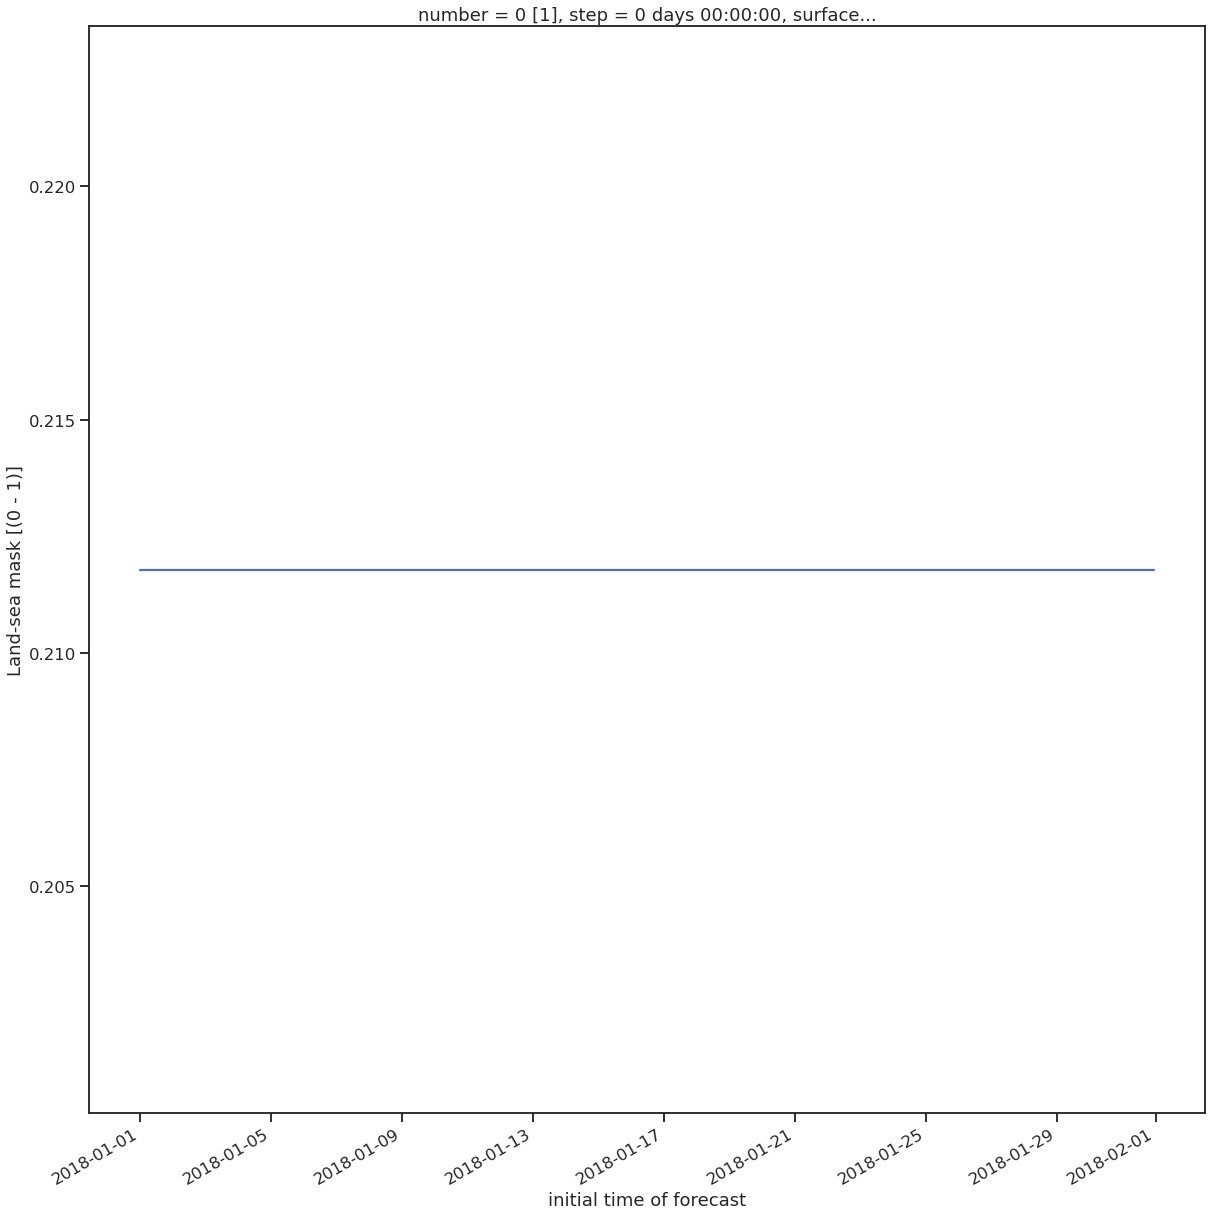

In [9]:
import numpy as np
unique_values = np.unique(lsm_ith_coordinate)
point_variance = lsm_ith_coordinate.std(dim='time')
print ('Number of unique values for this gridpoint is:', len(unique_values))
print ('Calculated standard deviation is :', point_variance.data)
lsm_ith_coordinate.plot()

Ok this is a float eps issue: we have only 1 unique value, but when calculating the standard deviation we get a non-zero

Rather than a using a continuous COV metric, we can actually just use a boolean: "Is this feature constant, yes or no?". This is done in `scripts/variability-boolean.py`.

## 1.1 Which features to use? Part II

In [10]:
#Data paths
boolean_files = glob.glob("../scripts/small_data/boolean*.pkl")

#Load it all
dfs = []
for f in boolean_files:
    df = pd.read_pickle(f)
    dfs.append(df)     


#...and put it into a single dataframe
df = pd.concat(dfs).reset_index()
df['time'] = pd.to_datetime(df['dt']) #make it a datetime object, not string

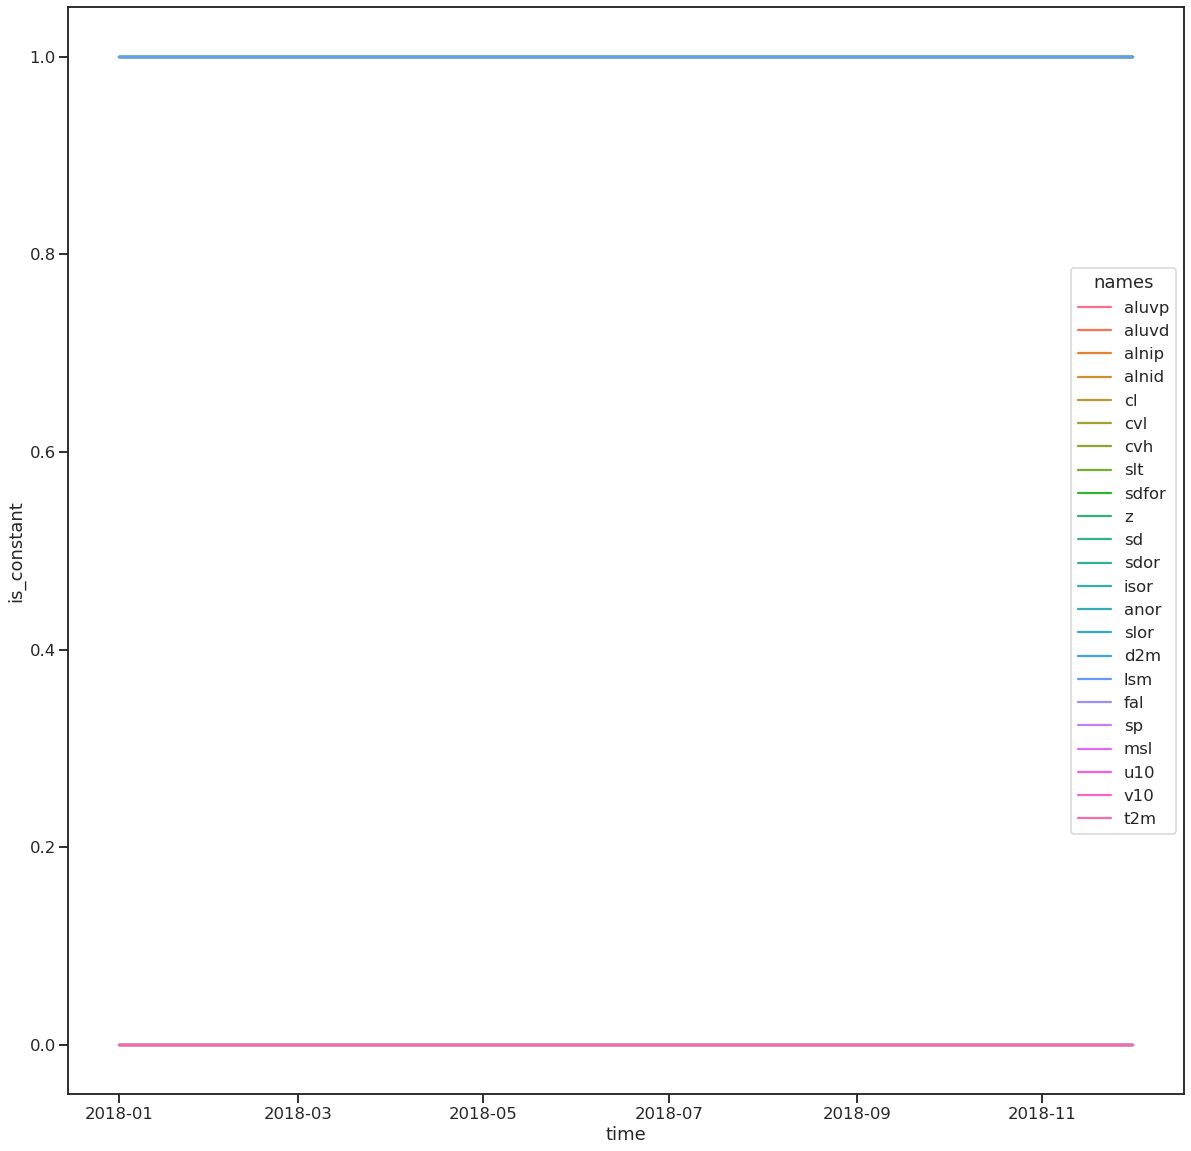

In [13]:
#Plot it 
import seaborn as sns
import matplotlib.pyplot as plt

h,w = 20,20

sns.set_theme(context='talk', 
                  style='ticks', 
                  palette='deep',
                  rc={'figure.figsize':(h,w)}
                  )

    
#Figure
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(h,w))
    
    #Plot
p = sns.lineplot(data=df, x='time', y='is_constant',hue='names',ax=ax1,markers=True)
  


In [14]:
df_grouped = df.groupby("names").mean()
df_grouped.sort_values("is_constant")

index  is_constant
names                    
alnid    3.0          0.0
alnip    2.0          0.0
aluvd    1.0          0.0
aluvp    0.0          0.0
u10      2.0          0.0
t2m      4.0          0.0
sp       0.0          0.0
d2m     15.0          0.0
fal     17.0          0.0
v10      3.0          0.0
msl      1.0          0.0
sd      10.0          0.0
slt      7.0          1.0
slor    14.0          1.0
sdor    11.0          1.0
lsm     16.0          1.0
isor    12.0          1.0
cvl      5.0          1.0
cvh      6.0          1.0
cl       4.0          1.0
anor    13.0          1.0
sdfor    8.0          1.0
z        9.0          1.0

In [15]:
selected_features = df_grouped.query("is_constant == 1.0").index.values

In [16]:
selected_features

array(['anor', 'cl', 'cvh', 'cvl', 'isor', 'lsm', 'sdfor', 'sdor', 'slor',
       'slt', 'z'], dtype=object)

These are the constant features we will use when we train our model to learn MODIS--->ERA

---


## 2. Plotting trained model


We train our model in `scripts/train_and_predict_GPU_inverse.py`

In [17]:
path = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ML_1648832119/'

import pandas as pd
df = pd.read_pickle(path+'predictions.pkl')

#Create some new columns for the errors
df['error'] = df.skt - df.predictions
df['error_abs'] = abs(df.skt - df.predictions)

#Surface some useful numbers
print('Absolute error:')
print('--------------------------------')
print("Mean error, Median error, Std deviation:",df.error_abs.mean(), df.error_abs.median(),df.error_abs.std())

print('Biased error:')
print('--------------------------------')
print("Mean bias, Median bia, Std deviation:",df.error.mean(), df.error.median(),df.error.std())




Absolute error:
--------------------------------
Mean error, Median error, Std deviation: 3.398798 2.6443787 3.0032668
Biased error:
--------------------------------
Mean bias, Median bia, Std deviation: -0.11768955 -0.40951538 4.5340505


In [21]:
import seaborn as sns
import matplotlib.pyplot as plt


def error_plot(df,x,grain):
    
    """
    Plotting function.
    df: data to plot
    x: What variable do you want the x-axis to be?
    grain: Precision of the x axis e.g. days. If int, then decimal precision
    relative: Boolean. Plot relative error or absolute error
    """

    
    
    
    
    #Some new columns used for plotting
    
    
    #Setup the x variable to plot.
    if x == 'time':
        df["X"] = df[x].dt.to_period(grain).dt.to_timestamp()
    else:
        df["X"] = df[x].round(grain) # Can also use .apply(lambda x: custom_round(x, base=2))
    
        
    #Group by
    df_plot = df.groupby(['X'],as_index=False).mean()
    
     #Setup plot env
    h,w = 20,20

    sns.set_theme(context='talk', 
                  style='ticks', 
                  palette='deep',
                  rc={'figure.figsize':(h,w)}
                  )

    
    #Figure
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(h,w))
    
    #Plot
    p = sns.lineplot(data=df_plot, x='X', y='error_NN_abs',ax=ax1,markers=True,label='NN')
    p = sns.lineplot(data=df_plot, x='X', y='error_ERA_abs',ax=ax1,markers=True,label='ERA')
    
    #Config
    ax1.set_xlabel('time', fontsize = 20)
    ax1.set_ylabel('Error [K]', fontsize = 20)


    

    #Other config
    ax1.legend().set_title(None)
    

        
import matplotlib.colors as mc
import matplotlib.colorbar as cb  
def plot_map(df,z,vmin,vmax,cmap,save):
    
    #Get all data as vectors
    x = df.longitude_ERA
    y = df.latitude_ERA
    z1 = df[z]
    
    #Scatter plot it
    # init the figure
    fig,[ax,cax] = plt.subplots(1,2, gridspec_kw={"width_ratios":[50,1]},figsize=(30, 20))

    
    norm = mc.Normalize(vmin=vmin, vmax=vmax)

    cb1 = cb.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
    
    
    sc = ax.scatter(x, y,
               s=1,
               c=cmap(norm(z1)),
               linewidths=1, alpha=.7
               )

    ax.set_title(z)
    
    if save is True:
        plt.savefig('example_image.png')
    plt.show()

In [22]:
ds_map = df.groupby(['latitude_ERA', 'longitude_ERA'],as_index=False).mean()




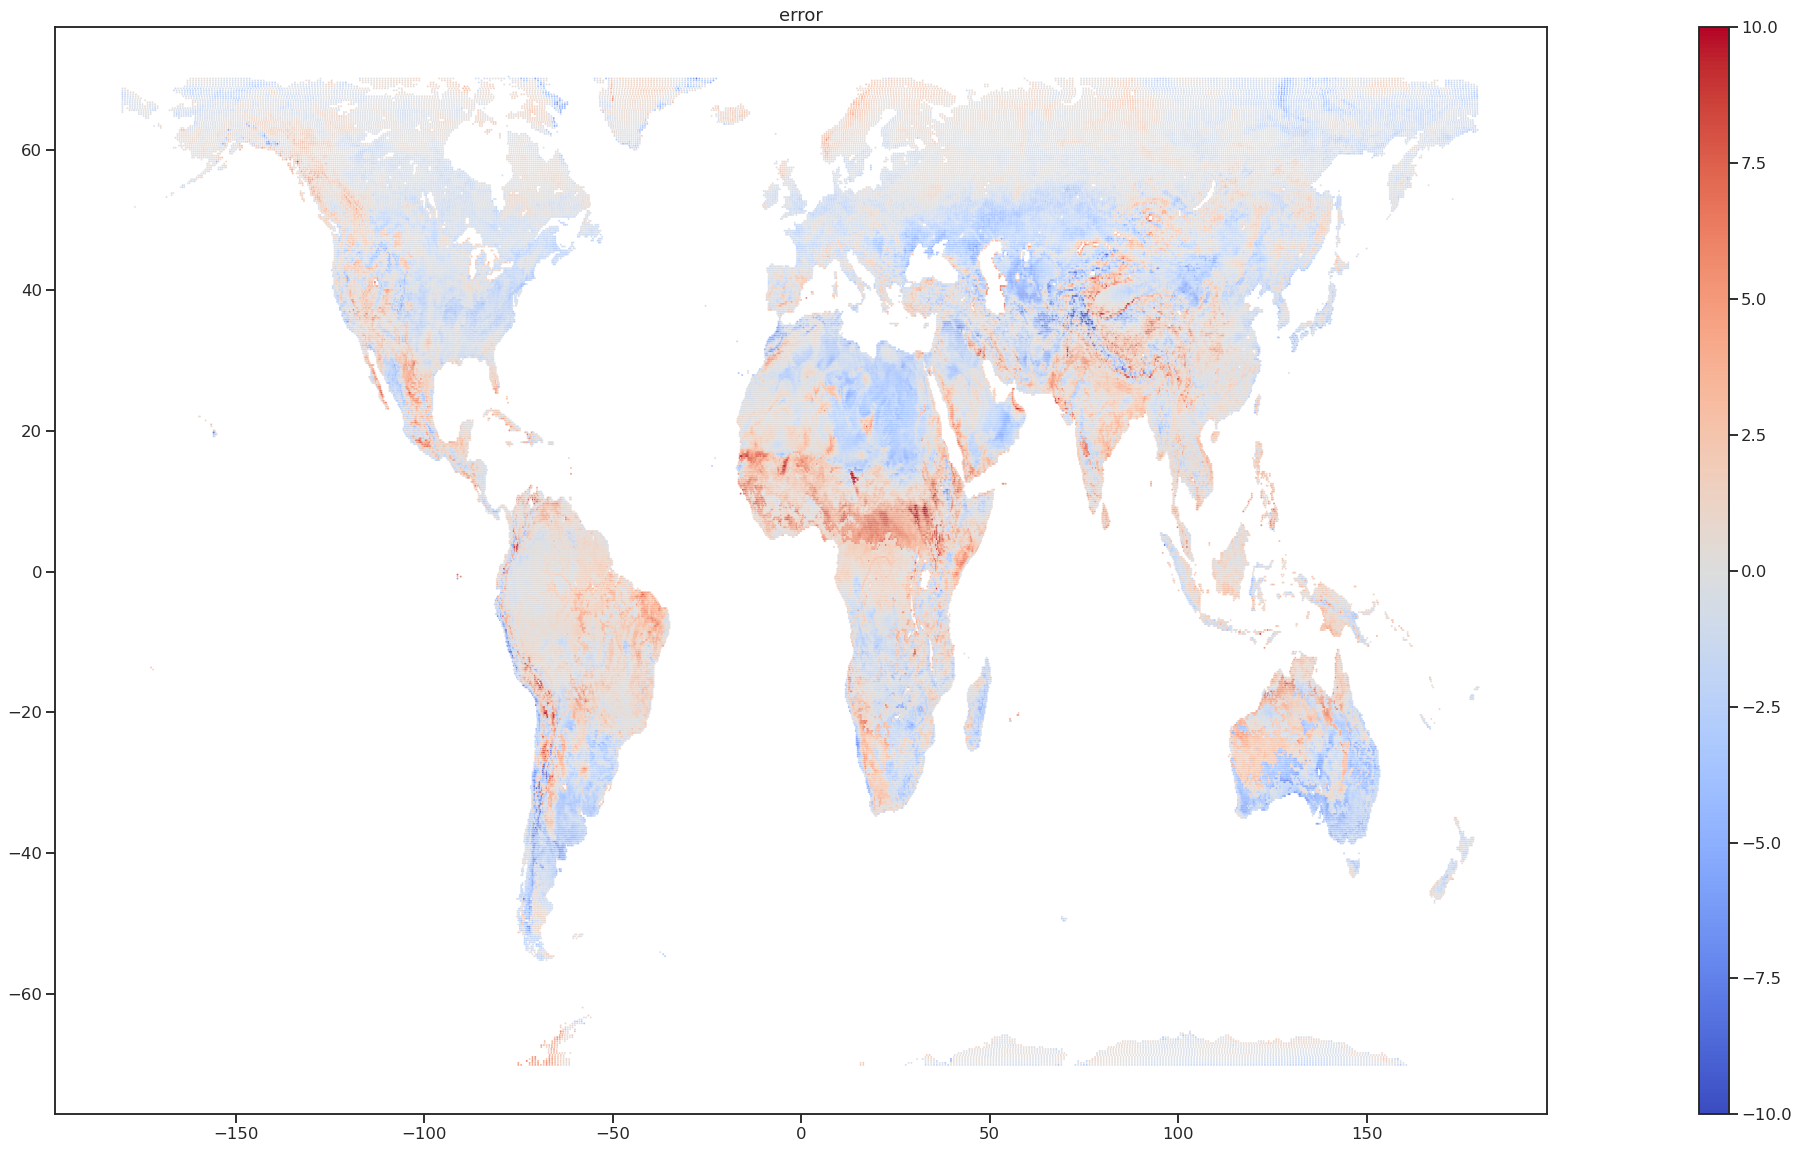

In [23]:
plot_map(ds_map,'error',vmin=-10,vmax=10,cmap = plt.cm.coolwarm,save=True)



In [26]:
def plot_distribution(d,bins,absolute_values):
    
    #seaborn histplot is quite slow for some reason?
    
    
      #Setup plot env
    h,w = 20,20

    sns.set_theme(context='talk', 
                  style='ticks', 
                  palette='deep',
                  rc={'figure.figsize':(h,w)}
                  )

    
    #Figure
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(h,w))
    
    
    #Plot    
    p1 = sns.histplot(data=d, x="error", ax=ax1,stat='probability', bins=bins,alpha=0.7,color='C0')


    
    # Config
    ax1.set_xlabel('Error', fontsize = 20)    
    ax1.axvline(0,c='0.5', linestyle='--')
    
    
    
    



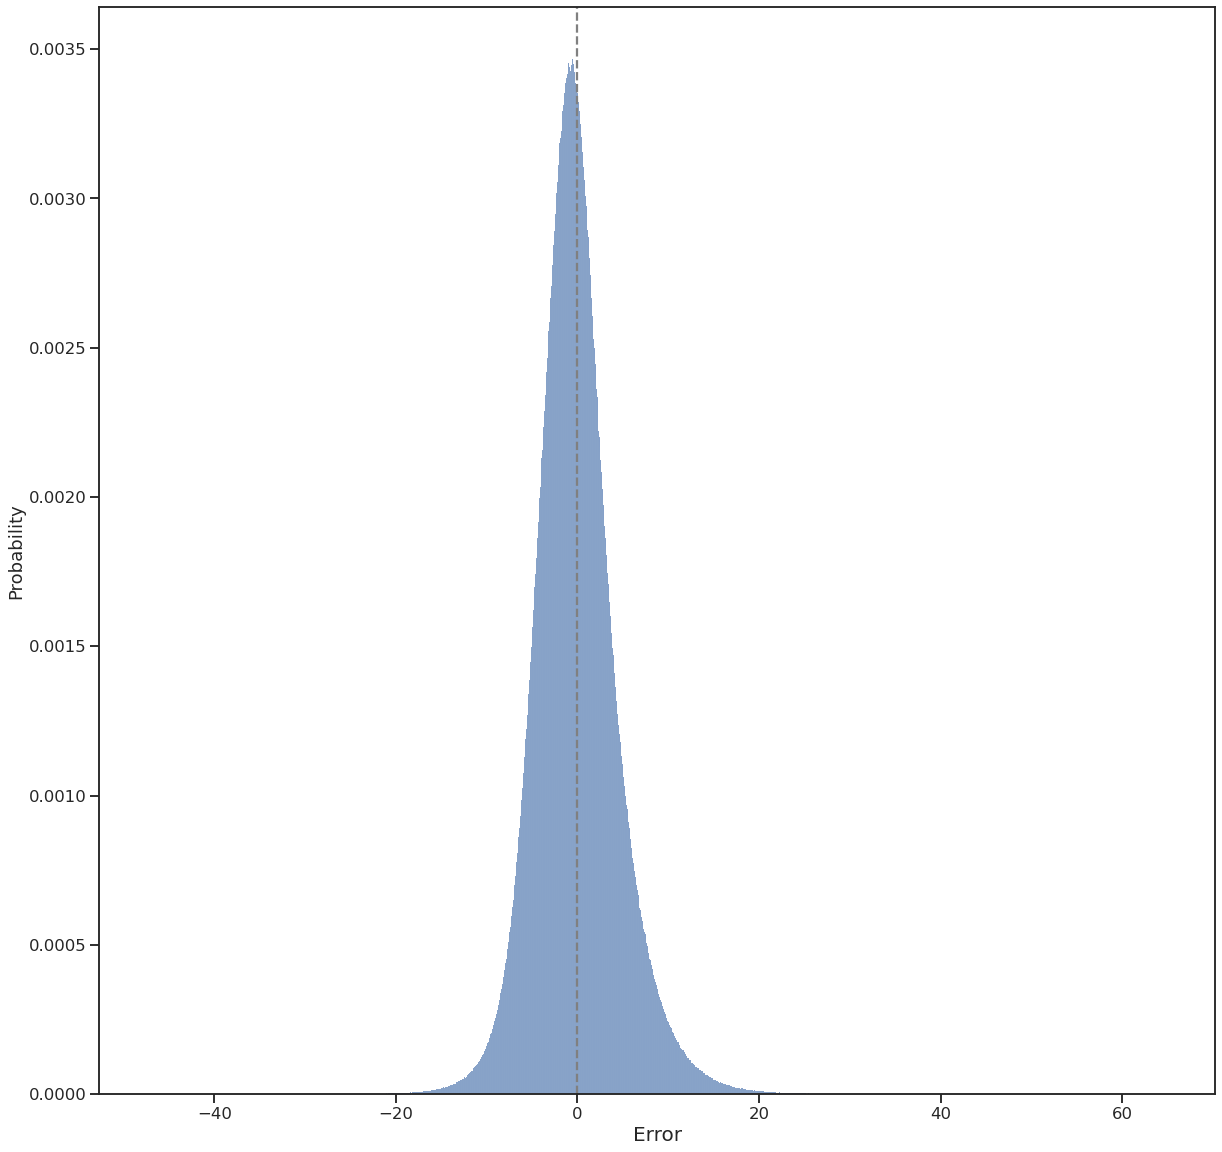

In [27]:
plot_distribution(df,bins='auto',absolute_values=False)